In [1]:
# check proportion of cars in "leasing" fleets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
datadir = '../data/dec2024/'

In [2]:
def read_file(fname, enc='iso8859-8'):
    fd = open(fname, encoding=enc, errors='replace')
    df = pd.read_csv(fd, sep='|')
    return df

def add_model(df):
    df['model'] = df.apply(lambda x: '_'.join([x[y] for y in ['tozeret_cd', 'degem_cd', 'shnat_yitzur']]), axis=1)

def get_model_name(ns):
    names = pd.DataFrame(data={'model':ns})
    ret = pd.merge(names, models, how='left', on='model')[['tozeret_nm', 'kinuy_mishari']]
    return ret

In [3]:
# map model to engine type using the list of all vehicles
cars = read_file('../data/dec2024/rechev.csv')

In [4]:
attributes = ['tozeret_cd', 'degem_cd']#, 'shnat_yitzur']

for a in attributes:
    cars[a] = cars[a].fillna(0).apply(float).astype(int)


In [5]:
cars['baalut'].value_counts()

פרטי      3390526
ליסינג     257029
חברה       170040
סוחר        54303
השכרה       37706
Name: baalut, dtype: int64

In [6]:
cars['sug_delek_nm'].value_counts()


בנזין         3282090
דיזל           389480
חשמל           153059
חשמל/בנזין      65013
גפמ"            19006
חשמל/דיזל         956
Name: sug_delek_nm, dtype: int64

In [9]:
cars['moed_aliya_lakvish'].head()

0    2019-2
1    2023-5
2    2017-3
3    2013-7
4    2022-8
Name: moed_aliya_lakvish, dtype: object

In [111]:
fuel = 'חשמל'
ownership = 'פרטי'
electric = cars.query('sug_delek_nm == @fuel')

In [112]:
counts = electric[['moed_aliya_lakvish', 'baalut']].value_counts().reset_index()

counts.rename(columns={0: 'counts', 'moed_aliya_lakvish': 'time'}, inplace=True)

/var/folders/l5/kkx8dwdn57s3v0k59p9m7sv80007gv/T/ipykernel_38851/1259459268.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_counts['time_formatted'] = filtered_counts['time'].dt.strftime('%Y-%m')


<Figure size 1500x800 with 0 Axes>

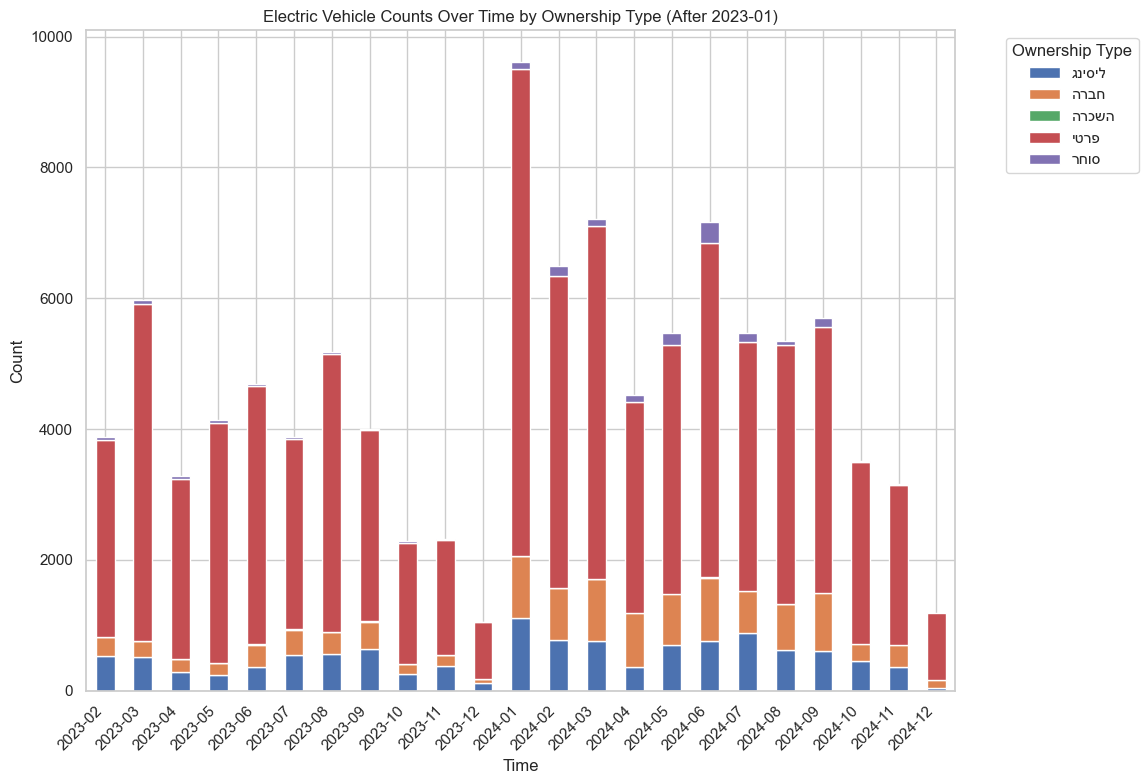

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_electric_vehicle_counts(counts, start_date='2023-01'):
    # Convert 'time' to datetime and filter for dates after start_date
    counts['time'] = pd.to_datetime(counts['time'])
    filtered_counts = counts[counts['time'] > start_date]

    # Format time as YYYY-MM and sort
    filtered_counts['time_formatted'] = filtered_counts['time'].dt.strftime('%Y-%m')
    filtered_counts = filtered_counts.sort_values('time')

    # Reverse strings for 'baalut' values
    filtered_counts['baalut_reversed'] = filtered_counts['baalut'].apply(lambda x: x[::-1])

    # Pivot the data for stacked bar plot
    pivot_data = filtered_counts.pivot(index='time_formatted', columns='baalut_reversed', values='counts').fillna(0)

    # Create the stacked bar plot
    plt.figure(figsize=(15, 8))
    ax = pivot_data.plot(kind='bar', stacked=True, figsize=(15, 8))

    plt.title(f'Electric Vehicle Counts Over Time by Ownership Type (After {start_date})')
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.legend(title='Ownership Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')

    # Reduce spacing between months
    plt.gca().margins(x=0.01)
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.2 # inch margin
    s = maxsize/plt.gcf().dpi*len(ax.get_xticks())+2*m
    margin = m/plt.gcf().get_size_inches()[0]
    plt.gcf().subplots_adjust(left=margin, right=1.-margin)
    plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

    plt.tight_layout()
    plt.show()

# Call the function
plot_electric_vehicle_counts(counts, start_date='2023-01')

In [114]:
energy_sales = pd.read_csv('../data/energy_sales.csv')
energy_sales.set_index(energy_sales.columns[0], inplace=True)
# Melt the DataFrame into a series
melted_energy_sales = energy_sales.melt(ignore_index=False, var_name='column', value_name='value').rename(columns={'value': 'energy_sales'  })

# Create new index by concatenating current index, dash, and column name
melted_energy_sales.index = melted_energy_sales.index.astype(str) + '-' + melted_energy_sales['column']

# Convert to a series and drop the 'column' index
energy_sales_series = melted_energy_sales['energy_sales'].apply(lambda x: float(str(x).replace(',', '')))

# Display the result
energy_sales_series

2023-1     219914.0
2024-1     437851.0
2023-2     238126.0
2024-2     478724.0
2023-3     272322.0
2024-3     528479.0
2023-4     286159.0
2024-4     574128.0
2023-5     292598.0
2024-5     605681.0
2023-6     316239.0
2024-6     688780.0
2023-7     360157.0
2024-7     741498.0
2023-8     401724.0
2024-8     780574.0
2023-9     343420.0
2024-9     721366.0
2023-10    340531.0
2024-10    682571.0
2023-11    322501.0
2024-11    677219.0
2023-12    371853.0
2024-12    766422.0
Name: energy_sales, dtype: float64

In [115]:
car_sales = pd.Series(electric['moed_aliya_lakvish'].value_counts(), name='car_sales')

def index_to_yyyymm_and_diff(df_in, start_date='2023-01'):

    df = df_in.copy()
    # Convert index to datetime
    df.index = pd.to_datetime(df.index)

    # Format index as YYYY-MM
    df.index = df.index.strftime('%Y-%m')

    # Sort in ascending order
    df = df.sort_index()

    # Compute difference from previous row
    df_diff = df.diff()

    df_diff = df_diff.reset_index().rename(columns={'index':'time'}).query("time >= @start_date")
    return df_diff

In [116]:
both = index_to_yyyymm_and_diff(energy_sales_series).merge(index_to_yyyymm_and_diff(car_sales), on='time').dropna()
both


,time,energy_sales,car_sales
1,2023-02,18212.0,-3169.0
2,2023-03,34196.0,2099.0
3,2023-04,13837.0,-2700.0
4,2023-05,6439.0,859.0
5,2023-06,23641.0,551.0
6,2023-07,43918.0,-806.0
7,2023-08,41567.0,1301.0
8,2023-09,-58304.0,-1182.0
9,2023-10,-2889.0,-1721.0
10,2023-11,-18030.0,37.0


In [117]:
# correlate car_sales and energy_sales (spearman)
correlation = both['energy_sales'].corr(both['car_sales'], method='spearman')
correlation


0.15513833992094864

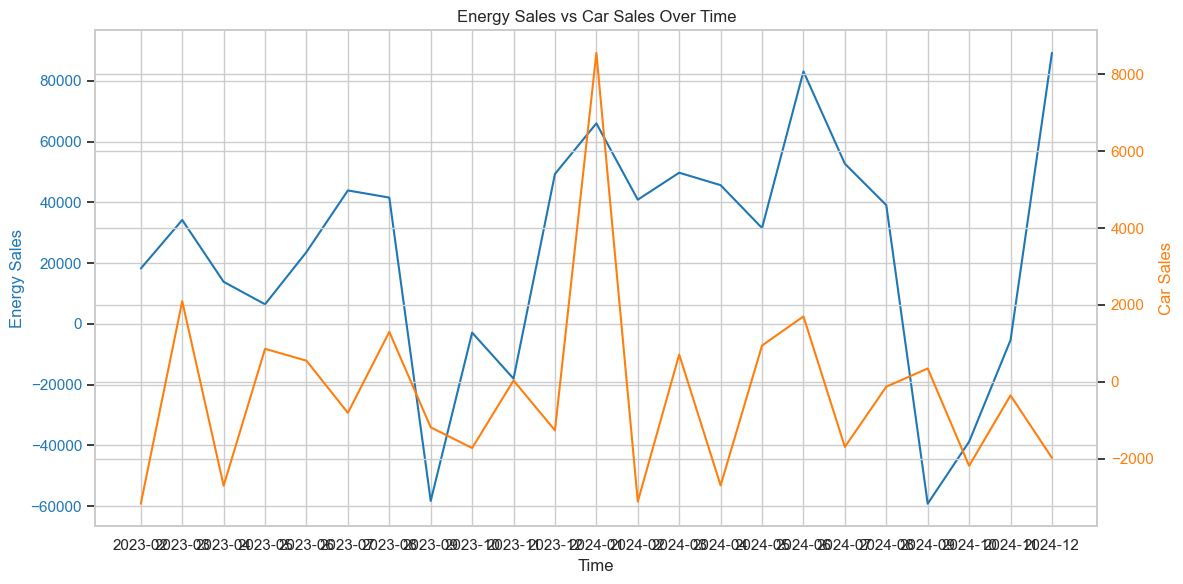

In [118]:
# Create the dual Y-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 'value' on the left Y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy Sales', color=color)
ax1.plot(both['time'], both['energy_sales'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second Y-axis
ax2 = ax1.twinx()

# Plot 'sales' on the right Y-axis
color = 'tab:orange'
ax2.set_ylabel('Car Sales', color=color)
ax2.plot(both['time'], both['car_sales'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Rotate x-axis labels for better readability

# Add title and adjust layout
plt.title('Energy Sales vs Car Sales Over Time')
fig.tight_layout()
plt.xticks(rotation=90, ha='right')

plt.show()
